In [2]:
import sys
sys.path.insert(0,'..')

from src.models import *
from src.loss_functions import *
from src.noise import *
from src.metrics import *
from src.plotting import *
from src.generate_data import *
from src.real_data import *

import sklearn
import pandas as pd

from scipy.stats import bernoulli


from operator import xor
from sklearn.preprocessing import StandardScaler


import pickle as pkl

In [3]:
features, labels, groups = load_dataset("support", include_groups = True)

In [4]:
features.shape
labels

array([0, 1, 1, ..., 0, 1, 0])

In [5]:
features, labels = balance_data(features, labels)

X_train, X_test, y_train, y_test = train_test_split(
    features, labels, test_size=0.2, random_state=2024)

In [6]:
print(X_train.shape)
print(y_test.shape)

(7756, 57)
(1940,)


In [7]:
def simulate_noise_and_train_model2(noise_levels, m, max_iter, d, X_train, y_train, X_test, y_test, p_y_x = np.array([0.5,0.5]), noise_type = "class_independent", uncertainty_type="backward",  model_type = "LR" , fixed_class=0, fixed_noise=0.2, feature_weights=None):
    
    if uncertainty_type == "forward":
        loss_types = ["BCE", "backward", "forward"]

    else: # backward
        loss_types = ["BCE"]

    
    metrics = MetricsStorage(loss_types, noise_levels)
    

    for base_seed, flip_p in (enumerate(tqdm(noise_levels))):

        if noise_type == "class_independent":
            yn_train, noise_transition_matrix = generate_class_independent_noise(y_train, flip_p)
        elif noise_type == "class_conditional":
            yn_train, noise_transition_matrix = generate_class_conditional_noise(y_train, flip_p, fixed_class, fixed_noise)
        elif noise_type == "instance_dependent":
            yn_train, noise_transition_dict = generate_instance_dependent_noise(y_train, X_train, flip_p, feature_weights)

        if uncertainty_type == "forward":
            y_vec = y_train
        else: # backward
            y_vec = yn_train

        preds_train_dict = {loss: [] for loss in loss_types}
        preds_test_dict = {loss: [] for loss in loss_types}

        typical_count = 0

        for seed in (range(1, max_iter+1)):

            if uncertainty_type == "forward":
                # Using a forward model, so get u directly
                u_vec = get_u(y_vec, noise_transition_matrix, seed=base_seed + seed)

            else:
                
                u_vec = infer_u(y_vec, noise_transition_matrix, p_y_x, seed=base_seed + seed)

            if noise_type == "instance_dependent":
                bool_flag = True
                for instance in np.unique(X_train, axis=0):
                    indices = [idx for idx, elem in enumerate(X_train) if np.array_equal(elem, instance)]

                    if not is_typical(u_vec[indices], noise_transition_matrix, y_vec[indices], p_y_x, noise_type=noise_type, uncertainty_type=uncertainty_type):
                        bool_flag = False
                        break
                if not bool_flag:
                    continue

            else:
                if not is_typical(u_vec, noise_transition_matrix, y_vec, p_y_x, noise_type=noise_type, uncertainty_type=uncertainty_type):
                    
                    continue

            flipped_labels = flip_labels(y_vec, u_vec)
            
            if uncertainty_type == "forward":
                for loss in loss_types:
                    model,  (noisy_train_loss,
                            clean_train_loss, 
                            noisy_train_acc,
                            clean_train_acc,
                            train_probs,
                            clean_test_loss, 
                            clean_test_acc,
                            test_probs
                            ) = train_model(X_train, y_train, flipped_labels, X_test, y_test, seed=base_seed + seed, num_epochs=50, batch_size=512, model_type = model_type, correction_type=loss, noise_transition_matrix=noise_transition_matrix)
                    
                    preds_train = (train_probs > 0.5).astype(int)
                    preds_test = (test_probs > 0.5).astype(int)

                    preds_train_dict[loss].append(preds_train)
                    preds_test_dict[loss].append(preds_test)

                    metrics.add_metric(loss, flip_p, "noisy_train_loss", noisy_train_loss)
                    metrics.add_metric(loss, flip_p, "clean_train_loss", clean_train_loss)
                    metrics.add_metric(loss, flip_p, "noisy_train_acc", noisy_train_acc*100)
                    metrics.add_metric(loss, flip_p, "clean_train_acc", clean_train_acc*100)
                    metrics.add_metric(loss, flip_p, "clean_test_loss", clean_test_loss)
                    metrics.add_metric(loss, flip_p, "clean_test_acc", clean_test_acc*100)

            elif uncertainty_type == "backward_torch":     
                for loss in loss_types:
                    model,  (noisy_train_loss,
                                train_loss, 
                                _,
                                train_acc,
                                train_probs,
                                test_loss, 
                                test_acc,
                                test_probs
                                ) = train_model(X_train, y_train, flipped_labels, X_test, y_test, seed = base_seed + seed, num_epochs=50, batch_size=512, model_type = model_type, correction_type=loss)
                        
                    preds_train = (train_probs > 0.5).astype(int)
                    preds_test = (test_probs > 0.5).astype(int)

                    preds_train_dict[loss].append(preds_train)
                    preds_test_dict[loss].append(preds_test)

                    metrics.add_metric(loss, flip_p, "train_loss", train_loss)
                    metrics.add_metric(loss, flip_p, "train_acc", train_acc*100)
                    metrics.add_metric(loss, flip_p, "test_loss", test_loss)
                    metrics.add_metric(loss, flip_p, "test_acc", test_acc*100)

            else: #backward_sk
                for loss in loss_types:
                    model,  (train_acc,
                            test_acc,
                            train_probs,
                            test_probs,
                            train_loss,
                            test_loss,
                            train_preds,
                            test_preds
                            ) = train_model_ours(X_train, flipped_labels, X_test, y_test, seed = base_seed + seed, model_type="LR")
                    
                    # train_preds = (train_probs > 0.5).astype(int)
                    # train_preds = (test_probs > 0.5).astype(int)

                    preds_train_dict[loss].append(train_preds)
                    preds_test_dict[loss].append(test_preds)

                    metrics.add_metric(loss, flip_p, "train_loss", train_loss)
                    metrics.add_metric(loss, flip_p, "train_acc", train_acc*100)
                    metrics.add_metric(loss, flip_p, "test_loss", test_loss)
                    metrics.add_metric(loss, flip_p, "test_acc", test_acc*100)

            typical_count += 1

            if typical_count == m:
                break
        
        for loss in loss_types:
            predictions_train = np.array(preds_train_dict[loss])

            predictions_test = np.array(preds_test_dict[loss])

            try:
                regret_train = calculate_error_rate(predictions_train, y_train)
                disagreement_train = estimate_disagreement(predictions_train)

                regret_test = calculate_error_rate(predictions_test, y_test)
                disagreement_test = estimate_disagreement(predictions_test)

            except:
                print("Error: Could not get Disagreement Metrics")
                continue

            for i, item in enumerate(X_test):
                metrics.add_metric(loss, flip_p, "regret_train", regret_train[i])
                metrics.add_metric(loss, flip_p, "disagreement_train", disagreement_train[i])

            for i, item in enumerate(X_test):
               
                metrics.add_metric(loss, flip_p, "regret_test", regret_test[i])
                metrics.add_metric(loss, flip_p, "disagreement_test", disagreement_test[i])

                #error_rates[loss][flip_p].append(error_rate[i])
                #disagreement_rates[loss][flip_p].append(disagreement_rate[i])

        print("Typical Rate: ", typical_count / seed)

    return metrics



In [14]:
noise_levels = np.linspace(0.0, 0.4, num=5)
noise_type = "class_independent"
fixed_class = 1
fixed_noise = 0.0

model_type = "LR"
uncertainty_type = "backward_sk"

max_iter = 1000
m = 100
d= X_train.shape[1]



X_train = X_train
y_train = y_train.astype(int)

y_test = y_test.astype(int)

np.unique(y_train, return_counts=True)

p1 = np.sum(y_train)/len(y_train)
p_y_x = np.array([1-p1,p1])
p_y_x

array([0.4996132, 0.5003868])

In [15]:
metrics = simulate_noise_and_train_model2(noise_levels, m, max_iter, d,  X_train, y_train, X_test, y_test, p_y_x = p_y_x, noise_type = noise_type, model_type = model_type, uncertainty_type=uncertainty_type,  fixed_class=fixed_class, fixed_noise=fixed_noise)
    

  0%|          | 0/5 [00:00<?, ?it/s]

Typical Rate:  1.0
Typical Rate:  0.9900990099009901
Typical Rate:  0.9900990099009901
Typical Rate:  0.9900990099009901
Typical Rate:  0.9900990099009901


/fs01/home/snagaraj/noise_multiplicity/src/../src/plotting.py:572: FutureWarning: Use "auto" to set automatic grayscale colors. From v0.14.0, "gray" will default to matplotlib's definition.
  sns.stripplot(x="Noise Level (%)", y="Rate (%)", hue="Loss Function", data=df, jitter=True, dodge=True,


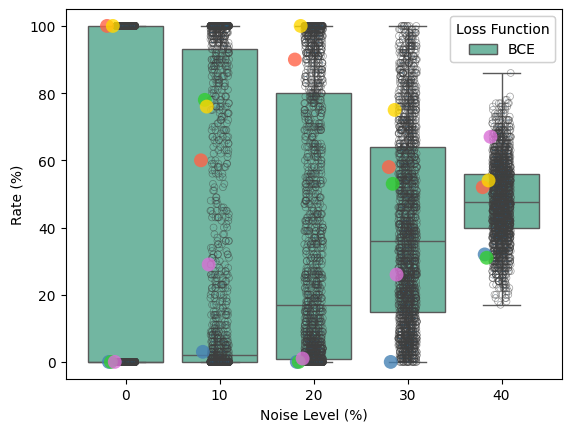

In [16]:
df = plot_metric(metrics, 'regret_test')

# or to plot on an existing axes:
# fig, ax = plt.subplots()
# plot_metric(metrics, 'BCE', 'clean_test_acc', ax=ax)
